In [2]:
import sys
from __future__ import annotations
import math
import random
from dataclasses import dataclass, field
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import plotly.graph_objects as go


import plotly.io as pio
# pio.renderers.default = "jupyterlab"
pio.renderers.default = "browser"


sys.executable

'c:\\Users\\thats\\AppData\\Local\\Programs\\Python\\Python311\\python.exe'

In [17]:
! pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
''' LOAD OR DF '''

or_df = pd.read_csv('or.csv', index_col=None)
or_df

,risk_factor,OR,CI_lower,CI_upper
0,BMI (per SD),1.13,1.01,1.26
1,HLA-DR4 heterozygous,1.94,1.50,2.50
2,HLA-DR4 homozygous,5.48,5.00,6.00
3,Smoking (alone),1.43,1.32,1.55
4,Smoking × heterozygous interaction,7.42,4.20,13.10
5,Smoking × homozygous interaction,15.70,7.20,34.20


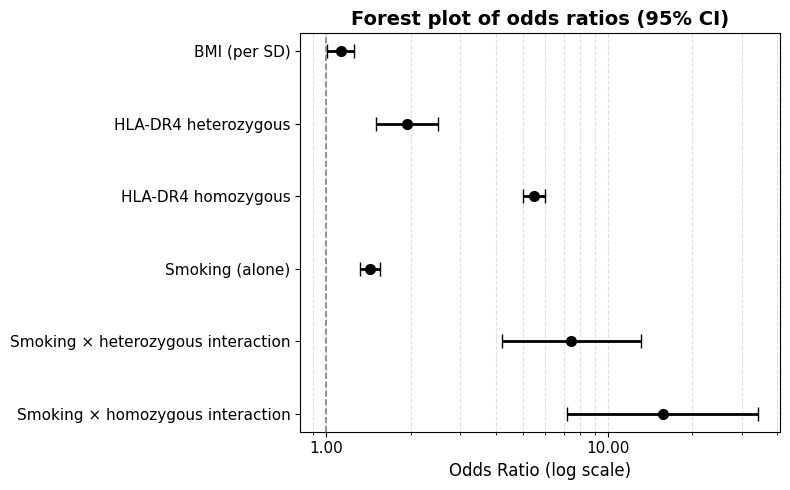

In [5]:
''' matplotlib forest '''

def forest_plot_from_df(
    df: pd.DataFrame,
    label_col: str = "risk_factor",
    or_col: str = "OR",
    lo_col: str = "CI_lower",
    hi_col: str = "CI_upper",
    title: str = "Forest plot of odds ratios (95% CI)",
):
    # Ensure plotting order = top to bottom as in DataFrame
    df_plot = df.reset_index(drop=True)
    y = np.arange(len(df_plot))[::-1]

    OR = df_plot[or_col].values
    LOWER = df_plot[lo_col].values
    UPPER = df_plot[hi_col].values

    # Asymmetric error bars
    xerr = np.vstack([OR - LOWER, UPPER - OR])

    fig, ax = plt.subplots(figsize=(8, 5))

    ax.errorbar(
        OR,
        y,
        xerr=xerr,
        fmt="o",
        markersize=7,
        markerfacecolor="black",
        markeredgecolor="black",
        elinewidth=2,
        capsize=5,
        ecolor="black",
    )

    # Reference line
    ax.axvline(1.0, color="gray", linestyle="--", linewidth=1.2)

    ax.set_yticks(y)
    ax.set_yticklabels(df_plot[label_col])
    ax.set_xlabel("Odds Ratio (log scale)", fontsize=12)
    ax.set_xscale("log")
    ax.set_title(title, fontsize=14, weight="bold")

    ax.tick_params(axis="both", labelsize=11)

    # Reasonable x-limits
    xmin = LOWER.min() * 0.8
    xmax = UPPER.max() * 1.2
    ax.set_xlim(xmin, xmax)

    ax.grid(True, axis="x", which="both", linestyle="--", alpha=0.4)

    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}"))

    plt.subplots_adjust(left=0.35)
    plt.tight_layout()
    plt.savefig("forest_plot_odds_ratios.png", dpi=300)
    plt.show()

forest_plot_from_df(or_df)

In [7]:
''' plotly forest '''

df_plot = or_df.copy()
df_plot = df_plot.iloc[::-1]  # top-to-bottom order

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_plot["OR"],
        y=df_plot["risk_factor"],
        mode="markers",
        marker=dict(size=10),
        error_x=dict(
            type="data",
            symmetric=False,
            array=df_plot["CI_upper"] - df_plot["OR"],
            arrayminus=df_plot["OR"] - df_plot["CI_lower"],
            thickness=2,
            width=6,
        ),
        hovertemplate=(
            "<b>%{y}</b><br>"
            "OR: %{x:.2f}<br>"
            "95% CI: [%{customdata[0]:.2f}, %{customdata[1]:.2f}]"
            "<extra></extra>"
        ),
        customdata=df_plot[["CI_lower", "CI_upper"]],
    )
)

# Reference line at OR=1
fig.add_vline(x=1.0, line_width=1)

fig.update_xaxes(
    type="log",
    tickformat=".2f",
    title="Odds Ratio",
)

fig.update_layout(
    title=dict(
        text="Forest plot of odds ratios (95% CI)",
        x=0.5,
        xanchor="center",
    ),
    height=400,
    margin=dict(l=200, r=50, t=60, b=40),
)

fig.show()